# Unforced trends in ZTG and ENSO in control simulations
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.io import loadmat
from matplotlib.patches import Polygon
from scipy import signal
from eofs.xarray import Eof
from scipy import stats
from statsmodels.regression.rolling import RollingOLS
import numpy.polynomial.polynomial as poly

Models - only one simulation per model

In [2]:
modelnames_fig = ['CCSM3 abrupt 4x', \
    'CESM1.0.4 abrupt 4x','CNRM-CM6.1 abrupt 4x', \
    'GFDL-CM3 1pct 2x','GFDL-ESM2M 1pct 2x', \
    'GISS-E2-R abrupt 4x','HadCM3L abrupt 4x', \
    'IPSL-CM5A-LR abrupt 4x', \
    'MIROC3.2 1pct 4x', \
    'MPIESM-1.2 abrupt 4x']

modelnames_control = ['CCSM3', \
    'CESM1.0.4','CNRM-CM6.1', \
    'GFDL-CM3','GFDL-ESM2M', \
    'GISS-E2-R','HadCM3L', \
    'IPSL-CM5A-LR', \
    'MIROC3.2', \
    'MPIESM-1.2']

modelnames_file = ['CCSM3_abrupt4x', \
    'CESM104_abrupt4x','CNRMCM61_abrupt4x', \
    'GFDLCM3_1pct2x','GFDLESM2M_1pct2x', \
    'GISSE2R_abrupt4x','HadCM3L_abrupt4x', \
    'IPSLCM5A_abrupt4x', \
    'MIROC32_1pct4x', \
    'MPIESM12_abrupt4x']


colors = [[0,238,0],[34,139,34],[135,206,255],[16,78,139],[30,144,255], \
          [255,110,180],[255,0,0], \
          [255,193,37],[122,55,139],[153,153,153]];

colors_double = []
for i in np.arange(0,len(colors),1):
    colors_double.append(colors[i])
    colors_double.append(colors[i])

Data locations

In [3]:
loc_nino34 = "../Data/ENSO_Indices/"
loc_ztg = "../Data/ZTG/"
loc_out = "../Data/ZTG_Trends/"
loc_hadisst = "~/" # change if running with raw data
loc_ersst = "~/" # change if running with raw data

Linear trend function

In [4]:
def linear_trend(ts):
    
    # This function finds the coefficient on the trend
    # on a timeseries (i.e. the regression of the timeseries on time)
    # it requires the numpy.polynomial.polynomial package
    
    # Create time variable
    X = np.arange(1,len(ts)+1,1)
    
    # Fit
    Z = poly.polyfit(X,ts,1)
    
    # Trend coefficient
    coef = Z[1]
    
    return(coef)

#### Analysis

Obs

In [5]:
trend_lengths = [25,35,50]

In [6]:
calculate_obs = False

In [7]:
if calculate_obs:
    hadisst = xr.open_dataset(loc_hadisst+"HadISST_sst.nc")
    sst = xr.DataArray(hadisst.data_vars["sst"])
    lat_sst = sst.coords["latitude"]
    lon_sst = sst.coords["longitude"]

    lat_min = -5
    lat_max = 5
    lon_min_nino3 = 210
    lon_max_nino3 = 270
    lon_min_nino4 = 160
    lon_max_nino4 = 210

    lon_min_nino3_180 = -150
    lon_max_nino3_180 = -90
    lon_min_nino4_180 = 160
    lon_max_nino4_180 = -150

    y1_ersst = 1958
    y2_ersst = 2017
    for yy in np.arange(y1_ersst,y2_ersst+1,1):
        if np.mod(yy,10) == 0:
            print(yy)
        for mm in np.arange(1,12+1,1):
            if mm < 10:
                strmm = "0"+str(mm)
            else:
                strmm = str(mm)
            ersst_file = xr.open_dataset(loc_ersst+"ersst.v5."+str(yy)+strmm+".nc")
            sst_ersst_in = xr.DataArray(ersst_file.data_vars["sst"])
            if ((yy == y1_ersst) & (mm == 1)):
                sst_ersst = sst_ersst_in.loc[:,:,lat_min:lat_max,lon_min_nino4:lon_max_nino3].squeeze("lev")
            else:
                sst_ersst = xr.concat([sst_ersst,sst_ersst_in.loc[:,:,lat_min:lat_max,lon_min_nino4:lon_max_nino3].squeeze("lev")],dim="time")

    nino3_hadisst = sst.loc[:,lat_max:lat_min,lon_min_nino3_180:lon_max_nino3_180].mean(axis=(1,2))
    nino4_hadisst = sst[:,:,((lon_sst <= lon_max_nino4_180) | (lon_sst >= lon_min_nino4_180))].loc[:,lat_max:lat_min,:].mean(axis=(1,2))
    ztg_hadisst = nino4_hadisst - nino3_hadisst
    time_sst = sst.coords["time"]

    nino3_ersst = sst_ersst.loc[:,lat_min:lat_max,lon_min_nino3:lon_max_nino3].mean(axis=(1,2))
    nino4_ersst = sst_ersst.loc[:,lat_min:lat_max,lon_min_nino4:lon_max_nino4].mean(axis=(1,2))
    ztg_ersst = nino4_ersst - nino3_ersst

    ztg_obs = ztg_hadisst.loc["1958-01-16":"2017-12-16"]
    time_obs = np.arange(0,len(ztg_obs),1)
    ztg_obs_hadisst = pd.DataFrame(np.transpose([ztg_obs,time_obs]),columns=["ZTG","Time"])
    ztg_obs_ersst = pd.DataFrame(np.transpose([ztg_ersst,time_obs]),columns=["ZTG","Time"])
    for tt in np.arange(0,len(trend_lengths),1):
        trend_model_hadisst = RollingOLS.from_formula("ZTG ~ Time",data=ztg_obs_hadisst,window=trend_lengths[tt]*12)
        trend_model_ersst = RollingOLS.from_formula("ZTG ~ Time",data=ztg_obs_ersst,window=trend_lengths[tt]*12)

        trend_fit_hadisst = trend_model_hadisst.fit()
        trend_fit_ersst = trend_model_ersst.fit()

        coefs_hadisst = trend_fit_hadisst.params["Time"].values
        coefs_ersst = trend_fit_ersst.params["Time"].values

        if tt == 0:
            trends_hadisst_1 = coefs_hadisst[~np.isnan(coefs_hadisst)]
            trends_ersst_1 = coefs_ersst[~np.isnan(coefs_ersst)]
            np.savetxt(loc_out+"HadISST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_hadisst_1,delimiter=",")
            np.savetxt(loc_out+"ERSST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_ersst_1,delimiter=",")
        elif tt == 1:
            trends_hadisst_2 = coefs_hadisst[~np.isnan(coefs_hadisst)]
            trends_ersst_2 = coefs_ersst[~np.isnan(coefs_ersst)]
            np.savetxt(loc_out+"HadISST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_hadisst_2,delimiter=",")
            np.savetxt(loc_out+"ERSST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_ersst_2,delimiter=",")
        else:
            trends_hadisst_3 = coefs_hadisst[~np.isnan(coefs_hadisst)]
            trends_ersst_3 = coefs_ersst[~np.isnan(coefs_ersst)]
            np.savetxt(loc_out+"HadISST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_hadisst_3,delimiter=",")
            np.savetxt(loc_out+"ERSST_trends_"+str(trend_lengths[tt])+"yr.csv",trends_ersst_3,delimiter=",")
else:
    trends_hadisst_1 = np.array([x[0] for x in pd.read_csv(loc_out+"HadISST_trends_"+str(trend_lengths[0])+"yr.csv").values])
    trends_ersst_1 = np.array([x[0] for x in pd.read_csv(loc_out+"ERSST_trends_"+str(trend_lengths[0])+"yr.csv").values])
    trends_hadisst_2 = np.array([x[0] for x in pd.read_csv(loc_out+"HadISST_trends_"+str(trend_lengths[1])+"yr.csv").values])
    trends_ersst_2 = np.array([x[0] for x in pd.read_csv(loc_out+"ERSST_trends_"+str(trend_lengths[1])+"yr.csv").values])
    trends_hadisst_3 = np.array([x[0] for x in pd.read_csv(loc_out+"HadISST_trends_"+str(trend_lengths[2])+"yr.csv").values])
    trends_ersst_3 = np.array([x[0] for x in pd.read_csv(loc_out+"ERSST_trends_"+str(trend_lengths[2])+"yr.csv").values])

Now plot distribution of 25, 35, 50-year trends in LongRunMIP control runs along with obs

In [8]:
ztg_trends_1 = []
ztg_trends_2 = []
ztg_trends_3 = []

In [9]:
for tt in np.arange(0,len(trend_lengths),1):
    print(str(trend_lengths[tt])+"-yr trends")
    
    for i in np.arange(0,len(modelnames_file),1):

        model, exp = modelnames_file[i].split("_")
        print(modelnames_file[i])

        #nino34_control = xr.DataArray(xr.open_dataset(loc_nino34+"nino34_"+model+"_control_anom_detrend.nc").data_vars["nino34"])

        if ((model == "MIROC32") | (model == "MPIESM12")):
            ztg_control = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_control.nc",decode_times=False).data_vars["ztg"])
        else:
            ztg_control = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_control.nc").data_vars["ztg"])

        n_months_ztg = ztg_control.shape[0]
        time_ztg = np.arange(0,n_months_ztg,1)

        #ztg_time_enso = pd.DataFrame(np.transpose([ztg_control,nino34_control,time_ztg]),columns=["ZTG","Nino3.4","Time"])
        ztg_time = pd.DataFrame(np.transpose([ztg_control,time_ztg]),columns=["ZTG","Time"])
        
        # rolling ztg trends
        trend_model = RollingOLS.from_formula("ZTG ~ Time",data=ztg_time,window=trend_lengths[tt]*12)
        trend_fit = trend_model.fit()
        coefs = trend_fit.params["Time"].values
        coefs_nan = coefs[~np.isnan(coefs)]*120
        
        if tt == 0:
            ztg_trends_1.append(coefs_nan)
        elif tt == 1:
            ztg_trends_2.append(coefs_nan)
        elif tt == 2:
            ztg_trends_3.append(coefs_nan)

25-yr trends
CCSM3_abrupt4x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


CESM104_abrupt4x
CNRMCM61_abrupt4x
GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_abrupt4x
HadCM3L_abrupt4x
IPSLCM5A_abrupt4x
MIROC32_1pct4x
MPIESM12_abrupt4x
35-yr trends
CCSM3_abrupt4x
CESM104_abrupt4x
CNRMCM61_abrupt4x
GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_abrupt4x
HadCM3L_abrupt4x
IPSLCM5A_abrupt4x
MIROC32_1pct4x
MPIESM12_abrupt4x
50-yr trends
CCSM3_abrupt4x
CESM104_abrupt4x
CNRMCM61_abrupt4x
GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_abrupt4x
HadCM3L_abrupt4x
IPSLCM5A_abrupt4x
MIROC32_1pct4x
MPIESM12_abrupt4x


In [10]:
names_all = ['HadISST','ERSST','CCSM3', \
    'CESM1.0.4','CNRM-CM6.1', \
    'GFDL-CM3','GFDL-ESM2M', \
    'GISS-E2-R','HadCM3L', \
    'IPSL-CM5A-LR', \
    'MIROC3.2', \
    'MPIESM-1.2']

In [11]:
def set_boxplot_col(b,n,c,c_double,lw,median):
    
    # This function sets the colors of a given boxplot b
    # It auto-sets the colors of the boxes, whiskers, caps, and fliers to c[m]
    # and it sets the colors of the medians if median=True
    # n is the number of instances of the boxplot and lw is the desired
    # linewidth
    # c should be a vector of colors
    
    for m in range(0,n*2,1):
        if m < n:
            b["boxes"][m].set(color=c[m],linewidth=lw)
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)
            b["fliers"][m].set(markeredgecolor=c[m])
            if median==True:
                b["medians"][m].set(color=c[m],linewidth=lw)
        else:
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/matplotlib/lines.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or np.any(self._markeredgecolor != ec)):
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

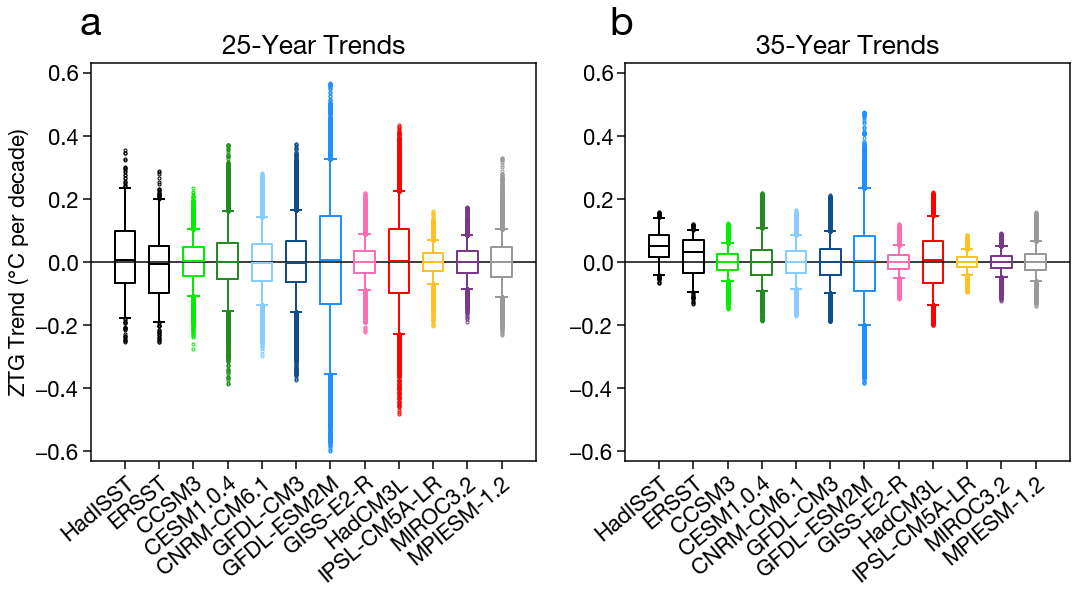

In [12]:
fig = plt.figure(figsize=(16,8))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 22.0
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.5


col = [0.8,0.2,0.2]
#col = "darkorange"

#cols = ["orange","green","blue","red","black","gray","purple"]

cols = [[0,238,0],\
          [34,139,34],[135,206,255],[16,78,139],[30,144,255], \
          [255,110,180],[255,0,0],\
          [255,193,37],[122,55,139],[153,153,153]];


gs5 = gridspec.GridSpec(1,2)
gs5.update(left=0.1,right=0.95,top=0.9,bottom=0.21,wspace=0.2,hspace=0.25)

pvals_hadisst = np.zeros((3,10))
pvals_ersst = np.zeros((3,10))

for tt in np.arange(0,len(trend_lengths)-1,1):
    
    ax = plt.subplot(gs5[0,tt])

    if tt == 0:
        ztg_trends = ztg_trends_1
        hadisst_trends = trends_hadisst_1*120
        ersst_trends = trends_ersst_1*120
    elif tt == 1:
        ztg_trends = ztg_trends_2
        hadisst_trends = trends_hadisst_2*120
        ersst_trends = trends_ersst_2*120
    elif tt == 2:
        ztg_trends = ztg_trends_3
        hadisst_trends = trends_hadisst_3*120
        ersst_trends = trends_ersst_3*120
    
    b1 = plt.boxplot(ztg_trends,positions=np.arange(1,11,1),whis=[5,95],
                     flierprops=dict(markersize=3),widths=0.6)
    set_boxplot_col(b1,10,np.array(colors)/255.,np.array(colors_double)/255.,2,True)
    
    b2 = plt.boxplot([hadisst_trends,ersst_trends],positions=[-1,0],whis=[5,95],
                     flierprops=dict(markersize=3),widths=0.6)
    black_cols = np.array(["black","black"])
    black_cols_double = np.array(["black","black","black","black"])
    set_boxplot_col(b2,2,black_cols,black_cols_double,2,True)
    
    plt.title(str(trend_lengths[tt])+"-Year Trends",pad=10)
    
    if tt == 0:
        plt.ylabel("ZTG Trend ($\degree$C per decade)")
    plt.ylim([-0.63,0.63])
    plt.xlim([-2,11])
    
    plt.xticks(ticks=np.arange(-1,11,1),labels=names_all,rotation=40,ha="right",
              rotation_mode="anchor")
    plt.axhline(y=0,linewidth=1.5,linestyle="-",color="black")
    

plt.figtext(0.09,0.95,"a",fontsize=40)
plt.figtext(0.55,0.95,"b",fontsize=40)

plt.savefig("../Figures/FigS12_ZTG_Trends.pdf")
plt.show()